<a href="https://colab.research.google.com/github/Fbanoy/ai_2023/blob/main/3.%20Unsupervised/Non_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load the packages

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#loads the packages to run the code

import numpy as np
import pandas as pd
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.animation as animation
import umap
from scipy import stats
import plotly.express as px
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.animation as animation
import time
import itertools

#for the autoencoder
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
#from scipy.spatial.distance import mahalanobis
#from scipy.stats import kurtosis
#from sklearn.manifold import TSNE

# Data functions




In [ ]:
# creates a dataframe from the data

def data_loader(data_type: str):
    # Toy data
    if data_type == 'Toy':
        df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                         header=None, 
                         names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])
        X = df.drop('species', axis=1)
        return X
    # Real data
    elif data_type == 'Real':
        url = "https://raw.githubusercontent.com/Fbanoy/ai_2023/2ad30048249d70bdd5b5a6f0106fbd164c062fae/3.%20Unsupervised/Mall_Customers.csv"
        df = pd.read_csv(url)
        return df
    else:
        print('No data for that input, the toy data will be loaded instead')
        return data_loader('Toy')


In [ ]:
def data_label():
    # Toy data
    df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                     header=None, 
                     names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])
    flower_map = {'Iris-setosa': 0, 'Iris-versicolour': 1, 'Iris-virginica': 2}
    X = df['species'].map(flower_map)
    return X

In [ ]:
def normalized(df):
    if not isinstance(df, pd.DataFrame):
      data = pd.DataFrame(df)
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
def split(data,train,test):
    random.shuffle(data)  # shuffle the data randomly
    n = len(data)
    train_size = int(train * n)
    test_size = int(test * n)
    train_set = data[:train_size]
    test_set = data[train_size:train_size+test_size]
    return train_set, test_set

In [ ]:
def assign_to_prototype(data, centers, metric_type):
    num_data = data.shape[0]
    num_center = centers.shape[0]
    dist_matrix = np.zeros((num_data, num_center))

    for i in range(num_data):
        for j in range(num_center):
            dist_matrix[i, j] = distance(data[i], centers[j], metric_type)

    return np.argmin(dist_matrix, axis=1)

# Real data preprocessing

Before working with the data, it is essential to ensure that there are no NaN or null values. Additionally, it is crucial to verify that each feature has data corresponding to the feature's data.


Since the *Iris* dataset has already been proven to work, the verification of conditions will only be performed on the *Mall_Customers* dataset.

In [ ]:
df=data_loader('Real')

df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [ ]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Based on this, it appears that the data is suitable for our cluster analysis without requiring any further fixes.

Now we create a method to calculate norms in the spaces 

# Norm function

In [ ]:
# method that defines the norms to use
def cosineDistance(u: np.ndarray, v: np.ndarray) -> float or int:
    Sc = np.dot(u, v) / (np.linalg.norm(u, ord=2) * np.linalg.norm(v, ord=2))
    # Check if Sc is NaN
    if np.isnan(Sc):
        return np.inf
    else:
        return np.max([(1 - Sc)**2, 0])

def mahalanobis(u: np.ndarray, v: np.ndarray) -> float or int:
    cov = np.cov(np.array([u, v]).T)
    # Compute the inverse of the covariance matrix or the pseudo-inverse if the matrix is singular.
    try:
        vi = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        vi = np.linalg.pinv(cov)
    delta = u - v
    return np.max([np.dot(np.dot(delta, vi), delta), 0])

def p_norm(x: np.ndarray, p:float=2) -> float or int:
    if p == np.inf:
        return np.max(np.abs(x))**2
    else:
        return np.sum(np.abs(x)**p)**(2/p)

    
def distance(u: np.ndarray, v: np.ndarray,
             type: str or float or int) -> float or int:
    u = u.squeeze()
    v = v.squeeze()
    if u.ndim == 1 and v.ndim == 1:
        if isinstance(type, float) or isinstance(type, int):
            return p_norm(u - v, type)
        elif isinstance(type, str):
            if type.lower() in ['mahal', 'mahalanobis']:
                return mahalanobis(u, v)
            elif type.lower() in ['cosine', 'cos']:
                return cosineDistance(u, v)
            else:
                raise ValueError("Invalid type.")
    else:
        raise ValueError("u and v must be vectors.")
    
def distanceMatrix(x, type):
    if x.ndim==2:
        n = x.shape[0]
        d = np.empty((n, n))
        for i in range(n):
            for j in range(n):
                u = x[i,:].squeeze()
                v = x[j,:].squeeze()
                if isinstance(type, float) or isinstance(type, int):
                    d[i,j] = p_norm(u - v, type)

                elif isinstance(type, str):
                    if type.lower() in ['mahal', 'mahalanobis']:
                        d[i,j] = mahalanobis(u, v)

                    elif type.lower() in ['cosine', 'cos']:
                        d[i,j] = cosineDistance(u, v)
                    else:
                        raise ValueError("Invalid type.")
                else:
                    raise ValueError("Invalid type.")
                
        return d

In [ ]:
def distance2(x, y, dist_type):
    """Distance function.
    
    Args:
        x (np.array): the first point.
        y (np.array): the second point.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
    
    Returns:
        float: the distance between the two n-dimensional points or vectors.
    """
    if dist_type == 1:
        return np.sum(np.abs(x - y))
    elif dist_type == 2:
        return np.sqrt(np.sum((x - y) ** 2))
    elif dist_type == "mahal":
        return np.sqrt((x-y).T @ np.linalg.inv(np.cov(x)) @ (x-y))
    elif dist_type == "cos":
        return 1 - np.dot(x, y) / (np.sqrt(np.sum(x ** 2)) * np.sqrt(np.sum(y ** 2)))
    else:
        raise ValueError("Invalid distance type.")

#Indices

In [ ]:
# Internal validation indices ----------------------------------------------------

# Davies-Bouldin index
def davies_bouldin_index(X, Y, C):
    """ Davies-Bouldin index. This index is a measure of how well a clustering algorithm
    separates the clusters. The lower the index, the better the clustering. The idea behind this index
    is to measure the distance between clusters and the distance between points within each cluster. It does so
    by calculating the average distance between each cluster and its points and the distance between each pair of clusters.
    This index is a measure of cohesion and separation, which means that it is a measure of how well the clusters are
    separated and how well the points are clustered within each cluster.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Davies-Bouldin index.
    """
    n_obs, n_features = X.shape
    k = len(np.unique(Y))
    # Calculate the distance between each pair of clusters.
    dist = np.zeros((k, k))
    for i, j in itertools.product(range(k), range(k)):
        if i != j:
            dist[i, j] = distance2(C[i,:], C[j,:], 2)
    # Calculate the average distance between each cluster and its points.
    avg_dist = np.zeros(k)
    for i in range(k):
        avg_dist[i] = np.mean(distance2(X[Y == i, :], C[i,:], 2))
    # Calculate the Davies-Bouldin index.
    DB = 0
    for i in range(k):
        max_dist = 0
        for j in range(k):
            if i != j:
                max_dist = max(max_dist, (avg_dist[i] + avg_dist[j]) / dist[i, j])
        DB = DB + max_dist
    DB = DB / k
    return DB

# Dunn index
def dunn_index(X, Y, C):
    """ Dunn index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the distance
    between clusters and the distance between points within each cluster. It does so by calculating the minimum
    distance between each cluster and its points and the maximum distance between each pair of clusters.
    This index is a measure of cohesion and separation, which means that it is a measure of how well the clusters are
    separated and how well the points are clustered within each cluster.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Dunn index.
    """
    n_obs, n_features = X.shape
    k = len(np.unique(Y))
    # Calculate the distance between each pair of clusters.
    dist = np.zeros((k, k))
    for i, j in itertools.product(range(k), range(k)):
        if i != j:
            dist[i, j] = distance2(C[i,:], C[j,:], 2)
    # Calculate the minimum distance between each cluster and its points.
    min_dist = np.zeros(k)
    for i in range(k):
        min_dist[i] = np.min(distance2(X[Y == i, :], C[i,:], 2))
    # Calculate the Dunn index.
    return np.min(min_dist) / np.max(dist)

# Calinski-Harabasz index
def calinski_harabasz_index(X, Y, C):
    """ Calinski-Harabasz index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the distance between
    clusters and the distance between points within each cluster. It does so by calculating the average distance between
    each cluster and its points and the distance between each pair of clusters. This index is a measure of cohesion and
    separation, which means that it is a measure of how well the clusters are separated and how well the points are
    clustered within each cluster.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Calinski-Harabasz index.
    """
    n_obs, n_features = X.shape
    k = len(np.unique(Y))
    # Calculate the distance between each pair of clusters.
    dist = np.zeros((k, k))
    for i, j in itertools.product(range(k), range(k)):
        if i != j:
            dist[i, j] = distance2(C[i,:], C[j,:], 2)
    # Calculate the average distance between each cluster and its points.
    avg_dist = np.zeros(k)
    for i in range(k):
        avg_dist[i] = np.mean(distance2(X[Y == i, :], C[i,:], 2))
    # Calculate the total average distance between all points and the global center.
    avg_dist_all = np.mean(distance2(X, np.mean(X, axis=0), 2))
    # Calculate the Calinski-Harabasz index.
    return (np.sum((k * avg_dist - avg_dist_all) ** 2)) / (k * np.sum(dist))

# Create a function to calculate the internal validation indices
def internal_validation_indices(X, Y, C):
    """ Calculate the internal validation indices. This function computes the Davies-Bouldin index,
    the Dunn index, and the Calinski-Harabasz index. Davies-Bouldin: lower is better, Dunn: higher is better,
    Calinski-Harabasz: higher is better.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Davies-Bouldin index.
        float: the Dunn index.
        float: the Calinski-Harabasz index.
    """
    DB = davies_bouldin_index(X, Y, C)
    DI = dunn_index(X, Y, C)
    CH = calinski_harabasz_index(X, Y, C)
    print(f"Davies-Bouldin index: {DB:.3f}, Dunn index: {DI:.3f}, Calinski-Harabasz index: {CH:.3f}")
    return DB, DI, CH

# External validation indices ---------------------------------------------------

# Rand index
def rand_index(Y, Y_hat):
    """ Rand index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the number of
    pairs of points that are correctly and incorrectly clustered. This index is a measure of the similarity
    between the true labels and the predicted labels.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Rand index.
    """
    n_obs = len(Y)
    a = 0
    b = 0
    c = 0
    d = 0
    for i, j in itertools.product(range(n_obs), range(n_obs)):
        if Y[i] == Y[j] and Y_hat[i] == Y_hat[j]:
            a = a + 1
        elif Y[i] != Y[j] and Y_hat[i] != Y_hat[j]:
            b = b + 1
        elif Y[i] == Y[j]:
            c = c + 1
        else:
            d = d + 1
    return (a + b) / (a + b + c + d)

# Jaccard index
def jaccard_index(Y, Y_hat):
    """ Jaccard index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the number of
    pairs of points that are correctly and incorrectly clustered. This index is a measure of the similarity
    between the true labels and the predicted labels.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Jaccard index.
    """
    n_obs = len(Y)
    a = 0
    b = 0
    c = 0
    for i, j in itertools.product(range(n_obs), range(n_obs)):
        if Y[i] == Y[j] and Y_hat[i] == Y_hat[j]:
            a = a + 1
        elif Y[i] != Y[j] and Y_hat[i] != Y_hat[j]:
            b = b + 1
        else:
            c = c + 1
    return a / (a + b + c)

# Fowlkes-Mallows index
def fowlkes_mallows_index(Y, Y_hat):
    """ Fowlkes-Mallows index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the number of
    pairs of points that are correctly and incorrectly clustered. This index is a measure of the similarity
    between the true labels and the predicted labels.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Fowlkes-Mallows index.
    """
    n_obs = len(Y)
    a = 0
    b = 0
    c = 0
    d = 0
    for i, j in itertools.product(range(n_obs), range(n_obs)):
        if Y[i] == Y[j] and Y_hat[i] == Y_hat[j]:
            a = a + 1
        elif Y[i] != Y[j] and Y_hat[i] != Y_hat[j]:
            b = b + 1
        elif Y[i] == Y[j]:
            c = c + 1
        else:
            d = d + 1
    return np.sqrt(a / (a + c)) * np.sqrt(a / (a + d))

# Create a function to calculate the external validation indices
def external_validation_indices(Y, Y_hat):
    """ Calculate the external validation indices. This function computes the Rand index, the Jaccard index,
    and the Fowlkes-Mallows index. Rand: higher is better, Jaccard: higher is better, Fowlkes-Mallows: higher is better.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Rand index.
        float: the Jaccard index.
        float: the Fowlkes-Mallows index.
    """
    RI = rand_index(Y, Y_hat)
    JI = jaccard_index(Y, Y_hat)
    FMI = fowlkes_mallows_index(Y, Y_hat)
    print(f"Rand index: {RI:.3f}, Jaccard index: {JI:.3f}, Fowlkes-Mallows index: {FMI:.3f}")
    return RI, JI, FMI

In [ ]:
# Transform membership matrix into cluster labels.
def membership_to_labels(membership):
    """ Transform membership matrix into cluster labels.
    
    Args:
        membership (np.array): the membership matrix.
        
    Returns:
        np.array: the resulting cluster labels.
    """
    return np.argmax(membership, axis=1)

# **Mountain Clustering Algorithm**
First we create a method that creates a mesh on the hypercupe [0,1] in the space of the data 

In [ ]:
def Grid(n, dim):
    coords = [np.linspace(0, 1, n) for i in range(dim)]
    outputcell = np.meshgrid(*coords, indexing='ij')
    output = np.zeros((dim, n**dim))

    for i in range(dim):
        outputcell[i] = outputcell[i].reshape(1, -1)
        output[i, :] = outputcell[i]
        output_t=np.transpose(output)

    return output_t

In [ ]:
def makendgrid(n_grid: int, ndim: int) -> np.ndarray:
    # Create a grid of n_grid points in each dimension that represents the hipercube [0,1]^ndim for a total of n^ndim points.
    meshgrid = np.array(np.meshgrid(*[np.linspace(0, 1, n_grid)]*ndim, indexing='ij'))
    return np.transpose(meshgrid.reshape(ndim,-1))

**We create the main algorith for the mountain clustering**

In [ ]:
def mountain_clustering_olguis(
        x: np.ndarray, # Data matrix.
        n_grid: int, # Number of points in each dimension of the hypercube.
        sigma: int or float = 0, # Sigma parameter for the Gaussian kernel.
        beta: int or float = 0, # Beta parameter for the Gaussian kernel.
        dist_type: str or float or int = 2,
        tol: float = 1e-3): # Distance type.
    n_obs, n_features = x.shape
    if sigma == 0:
        sigma = 1 / n_grid

    if beta == 0:
        beta = 2*sigma
        hypercube = makendgrid(n_grid, n_features)
        ncoords = n_grid**n_features

    # Create equally spaced coordinates in the hypercube [0,1]^n_features.
    if ncoords < 1e6:
        
        # hypercube = makendgrid(n_grid, n_features)
        # hypercube = makehullndgrid(x, n_grid=n_grid)
        # ncoords = hypercube.shape[0]
        
        k = 100
        centers = np.zeros((k, n_features))
        idx_centers = np.zeros(k, dtype=np.int32)
        mount_centers = np.zeros(k)
        mountain = np.zeros(ncoords)
        i = 0
        while True:
            if i == 0:
                for i1, coord in enumerate(hypercube):
                    for j in range(n_obs):
                        mountain[i1] = mountain[i1] + np.exp(-distance(coord, x[j,:], dist_type) / (2*sigma**2))
            else:
                for i1, coord in enumerate(hypercube):
                    for j in range(n_obs):
                        mountain[i1] = mountain[i1] - mount_centers[i-1] * np.exp(-distance(coord, centers[i-1], dist_type) / (2*beta**2))
            
            idx_centers[i] = int(np.argmax(mountain))
            new_center = hypercube[idx_centers[i], :]
            # Stop criteria Check if the new center is already in the list of centers or if the mountain value is too small.
            if any(np.equal(centers, new_center).all(axis=1)) or\
                abs(mountain[idx_centers[i]]) < min(tol, 0.5/(n_grid-1)):
                centers = centers[:i, :]
                idx_centers = idx_centers[:i]
                mount_centers = mount_centers[:i]
                break

            centers[i, :] = new_center
            mount_centers[i] = mountain[idx_centers[i]]
            i = i + 1

    else:
        raise ValueError('The number of coordinates is too large.')
        # hypercube = makefastndrid(n_grid, n_features)
    
    return centers, idx_centers, mount_centers, mountain

In [ ]:
def plot_group_3d(X, centers, metric_type):
  assignments = assign_to_prototype(X, centers, metric_type)
  i, j, k = 0, 1, 2
  fig = px.scatter_3d(X, x=X[:,i], y=X[:,j], z=X[:,k], color=assignments, opacity=0.25)
  fig.add_scatter3d(x=centers[:,i], y=centers[:,j], z=centers[:,k], mode='markers',
                  marker=dict(size=2, color='black'))

  fig.show()

In [ ]:
def plot_group_2d(X, centers, metric_type):
  assignments = assign_to_prototype(X, centers, metric_type)
  i, j = 0, 1
  fig = px.scatter(X, x=X[:,i], y=X[:,j], color=assignments, opacity=0.25)
  fig.add_scatter(x=centers[:,i], y=centers[:,j], mode='markers',
                  marker=dict(size=5, color='black'))

  fig.show()

## Iris Example

In [ ]:
data=data_loader('Toy')
data=normalized(data)
data = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].iloc[: , :].values

In [ ]:
centers, idx_centers, mount_centers, mountain = mountain_clustering_olguis(data,6,sigma=0.1,dist_type=2)

In [ ]:
centers

array([[0.2, 0.6, 0. , 0. ],
       [0.6, 0.4, 0.6, 0.6]])

In [ ]:
plot_group_3d(data, centers, 2)

The mountain cluster algorithm applied to the iris dataset resulted in the conclusion that only one cluster was found. This suggests that the data points in the dataset are closely related and do not exhibit distinct groupings that would warrant multiple clusters. However, it is important to note that the chosen parameters and settings for the algorithm can greatly impact the clustering results, and different parameter settings or algorithms could lead to different conclusions regarding the number of clusters present in the dataset. Therefore, it is crucial to carefully select appropriate parameters and settings based on the dataset characteristics and research question.

The finding of only one cluster in the iris dataset using the mountain cluster algorithm provides insights into the underlying structure and relationships within the data, which can be used to inform further analysis and modeling efforts. However, it is also essential to consider the impact of the chosen parameters on this result, and further exploration and experimentation may be necessary to fully understand the dataset's structure. In summary, while the result of one cluster in the iris dataset is informative, it is important to interpret it within the context of the chosen parameters and to conduct additional analysis to ensure that the clustering solution is meaningful and robust.

As this was an example only one combination of parameters was used, in the real data scenario more experiments will be needed

# **Reduction** algorithm

In [ ]:
def reduction_no_cluster_num(x: np.ndarray, # Data matrix.
        sigma: int or float, # Sigma parameter for the Gaussian kernel.
        beta: int or float = 0, # Beta parameter for the Gaussian kernel.
        dist_type: str or float or int = 2, # Distance type.
        tol: float = 1e-3): # Tolerance parameter for the stop criteria.
    n_obs, n_features = x.shape

    if beta == 0:
        beta = 2*sigma

    k = 100
    centers = np.zeros((k, n_features))
    idx_centers = np.zeros(k, dtype=np.int32)
    density_centers = np.zeros(k)
    density = np.zeros(n_obs)

    i = 0
    while True:
        if i == 0:
            for j in range(n_obs):
                for l in range(n_obs):
                    density[j] += np.exp(-distance(x[j,:], x[l,:], dist_type) / (sigma/2)**2)
        else:

            for j in range(n_obs):
                density[j] -= density_centers[i-1] * np.exp(-distance(x[j,:], centers[i-1], dist_type) / (beta/2)**2)
        
        idx_centers[i] = int(np.argmax(density))
        new_center = x[idx_centers[i], :]
        new_density = density[idx_centers[i]]
        # Stop criteria Check if the new center is already in the list of centers or if the mountain value is too small.
        if i > 0:
            if any(np.equal(centers, new_center).all(axis=1)) or\
                abs(new_density) < tol or\
                abs(new_density / density_centers[i-1]) < 1e-1:
                centers = centers[:i, :]
                idx_centers = idx_centers[:i]
                density_centers = density_centers[:i]
                break
        centers[i, :] = new_center
        density_centers[i] = new_density

        i = i + 1


    
    return centers, idx_centers, density_centers, density

## Iris Example

In [ ]:
data=data_loader('Toy')
data=normalized(data)
data = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].iloc[: , :].values

In [ ]:
centers, idx_centers, density_centers, density = reduction_no_cluster_num(data,0.07*8,dist_type=2)

In [ ]:
centers

array([[0.47222222, 0.375     , 0.59322034, 0.58333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.69444444, 0.41666667, 0.76271186, 0.83333333]])

In [ ]:
plot_group_3d(data, centers, 2)

The reduction algorithm applied to the iris dataset resulted in the conclusion that two clusters were found. This suggests that the data points in the dataset exhibit distinct groupings that can be separated into two distinct clusters. However, it is important to note that the chosen parameters and settings for the reduction algorithm can greatly impact the clustering results, and different parameter settings or algorithms could lead to different conclusions regarding the number of clusters present in the dataset. Therefore, it is crucial to carefully select appropriate parameters and settings based on the dataset characteristics and research question.

The finding of two clusters in the iris dataset using the reduction algorithm provides valuable insights into the underlying structure and relationships within the data. This result can be used to inform further analysis and modeling efforts, such as the development of classification models that can accurately classify new instances into the two identified clusters. However, it is important to consider the impact of the chosen parameters on this result, and further exploration and experimentation may be necessary to fully understand the dataset's structure. In summary, while the result of two clusters in the iris dataset is informative, it is important to interpret it within the context of the chosen parameters and to conduct additional analysis to ensure that the clustering solution is meaningful and robust.

# **k means** algorithm

In [ ]:
def kmeans(
        x: np.ndarray, # Data matrix.
        k: int, # Number of clusters.
        max_iter: int = 100, # Maximum number of iterations.
        tol: float = 1e-3, # Tolerance parameter for the stop criteria.
        dist_type: str or float or int = 2, # Distance type.
        init: list = []): # Initialization centers.
    n_obs = x.shape[0]
    # Initialization of the centers.
    if init == [] or len(init) != k:
        init = np.random.choice(n_obs, k, replace=False)
    centers = x[init, :]
    costs = np.zeros(max_iter+1)
    iteration = 0
    while True:
        # Determine of membership of each observation to each cluster.
        membership = np.zeros((n_obs, n_obs), dtype=np.int32)
        for j in range(n_obs):
            min_dist = np.inf
            min_idx = 0
            for i, center in enumerate(centers):
                dist = distance(x[j,:], center, dist_type)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = i
            membership[j, min_idx] = 1

        # Compute the cost function.
        cost = 0
        for j in range(n_obs):
            for i in range(k):
                if membership[j, i] == 1:
                    cost = cost + distance(x[j,:], centers[i,:], dist_type)
        
        costs[iteration-1] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1:
            if abs(cost - costs[iteration-2]) < tol or iteration > max_iter:
                break
        # Update the centers.
        for i in range(k):
            centers[i, :] = np.mean(x[membership[:, i] == 1, :], axis=0)

        iteration = iteration + 1
        
    return centers, membership, costs

## Iris Example

In [ ]:
data=data_loader('Toy')
data=normalized(data)
data = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].iloc[: , :].values

In [ ]:
centers, membership, costs = kmeans(data,3)

In [ ]:
plot_group_3d(data, centers, 2)

Indices

In [ ]:
predicted_labels=membership_to_labels(membership)

In [ ]:
labels = data_label()

In [ ]:
DB, DI, CH = internal_validation_indices(data,labels,centers)

Davies-Bouldin index: 16.773, Dunn index: 0.000, Calinski-Harabasz index: 49.465


In [ ]:
RI,JI,FMI = external_validation_indices(labels,predicted_labels)

Rand index: 0.789, Jaccard index: 0.177, Fowlkes-Mallows index: 0.642


#fuzzy c means

In [ ]:
def fuzzyCmeans(
        x: np.ndarray, # Data matrix.
        k: int, # Number of clusters.
        m: int or float = 2, # Fuzziness parameter.
        max_iter: int = 100, # Maximum number of iterations.
        tol: float = 1e-3, # Tolerance parameter for the stop criteria.
        dist_type: str or float or int = 2): # Distance type.
    n_obs, n_features = x.shape
    # Initialization the membership matrix.
    membership = np.random.rand(n_obs, k)
    membership = membership / np.sum(membership, axis=1, keepdims=True)

    iteration = 0
    centers = np.zeros((k, n_features))
    costs = np.zeros(max_iter+1)
    while True:
        # Calculate the centers.
        for i in range(k):
            centers[i, :] = membership[:, i] ** m @ x / np.sum(membership[:, i] ** m)

        # Compute the cost function.
        cost = 0
        for i in range(k):
            for j in range(n_obs):
                cost = cost + membership[j, i] ** m * distance(centers[i,:], x[j,:], dist_type)
        costs[iteration] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1:
            if abs(cost - costs[iteration-2]) < tol or iteration > max_iter:
                break
        # Update the membership matrix.
        for i in range(k):
            for j in range(n_obs):
                den = 0
                for l in range(k):
                    den = den + (distance(x[j,:], centers[i,:], dist_type) / distance(x[j,:], centers[l,:], dist_type)) ** (2/(m-1))
                membership[j, i] = 1 / den

        iteration = iteration + 1

    
    return centers, membership, costs

##Iris Example

In [ ]:
data=data_loader('Toy')
data=normalized(data)
data = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].iloc[: , :].values

In [ ]:
centers, membership, costs= fuzzyCmeans(data,3)

In [ ]:
plot_group_3d(data, centers, 2)

In [ ]:
predicted_labels=membership_to_labels(membership)

In [ ]:
labels = data_label()

In [ ]:
DB, DI, CH = internal_validation_indices(data,labels,centers)

Davies-Bouldin index: 16.207, Dunn index: 0.000, Calinski-Harabasz index: 49.277


In [ ]:
RI,JI,FMI = external_validation_indices(labels,predicted_labels)

Rand index: 0.789, Jaccard index: 0.177, Fowlkes-Mallows index: 0.642


# **k medoids** algorithm

In [ ]:
def k_medoids(x: np.ndarray, # Data matrix.
              k: int, # Number of clusters.
              max_iter: int = 100, # Maximum number of iterations.
              tol: float = 1e-3, # Tolerance parameter for the stop criteria.
              dist_type: str or float or int = 2): # Distance type.):
    # Check if the number of clusters is valid.
    if k < 1:
        raise ValueError("k must be greater than 0.")
    # Check if the number of iterations is valid.
    if max_iter < 1:
        raise ValueError("max_iter must be greater than 0.")
    # Check if the tolerance parameter is valid.
    if tol < 0:
        raise ValueError("tol must be greater than 0.")
    # Check if the data matrix is valid.
    if x.ndim != 2:
        raise ValueError("x must be a matrix.")
    # Check if the distance type is valid.
    if not isinstance(dist_type, str) and not isinstance(dist_type, float) and not isinstance(dist_type, int):
        raise ValueError("dist_type must be a string or a number.")
    # Check if the distance type is valid.
    if isinstance(dist_type, str) and dist_type.lower() not in ['mahal', 'mahalanobis', 'cosine', 'cos']:
        raise ValueError("dist_type must be 'mahal', 'mahalanobis', 'cosine' or 'cos'.")
    # Check if the distance type is valid.
    if isinstance(dist_type, float) and dist_type < 1:
        raise ValueError("dist_type must be greater than 1.")
    # Check if the distance type is valid.
    if isinstance(dist_type, int) and dist_type < 1:
        raise ValueError("dist_type must be greater than 1.")
    # Check if the number of clusters is valid.
    if k > x.shape[0]:
        raise ValueError("k must be less than or equal to the number of samples.")
    # Check if the number of clusters is valid.
    if k == x.shape[0]:
        return np.arange(x.shape[0]), np.zeros(x.shape[0])
    # Initialize the medoids.
    medoids = np.random.choice(x.shape[0], k, replace=False)
    # Initialize the clusters.
    clusters = np.zeros(x.shape[0])
    # Initialize the cost.
    cost = np.inf
    # Initialize the number of iterations.
    n_iter = 0
    # Iterate until the stop criteria is met.
    while n_iter < max_iter:
        # Compute the distance matrix.
        d = distanceMatrix(x, dist_type)
        # Assign each sample to the closest medoid.
        for i in range(x.shape[0]):
            clusters[i] = np.argmin(d[i, medoids])
        # Update the medoids.
        for i in range(k):
            # Compute the cost of each sample.
            cost_samples = np.sum(d[np.where(clusters == i)[0], :][:, np.where(clusters == i)[0]], axis=1)
            # Update the medoid if the cost is lower.
            if np.min(cost_samples) < cost:
                medoids[i] = np.where(clusters == i)[0][np.argmin(cost_samples)]
                cost = np.min(cost_samples)
        # Update the number of iterations.
        n_iter += 1
    # Return the medoids and the clusters.
    return x[medoids,:], clusters


## Iris Example

In [ ]:
data=data_loader('Toy')
data=normalized(data)
data = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].iloc[: , :].values

In [ ]:
medoids, clusters = k_medoids(data,3)

In [ ]:
plot_group_3d(data, medoids, 2)

In [ ]:
labels = data_label()

In [ ]:
DB, DI, CH = internal_validation_indices(data,labels,medoids)

Davies-Bouldin index: 13.706, Dunn index: 0.000, Calinski-Harabasz index: 11.067


In [ ]:
RI,JI,FMI = external_validation_indices(labels,clusters)

Rand index: 0.758, Jaccard index: 0.171, Fowlkes-Mallows index: 0.603


#Real Data Applications

## Normal Data

In [ ]:
data=data_loader('Real')
data = df[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values
data=normalized(data)

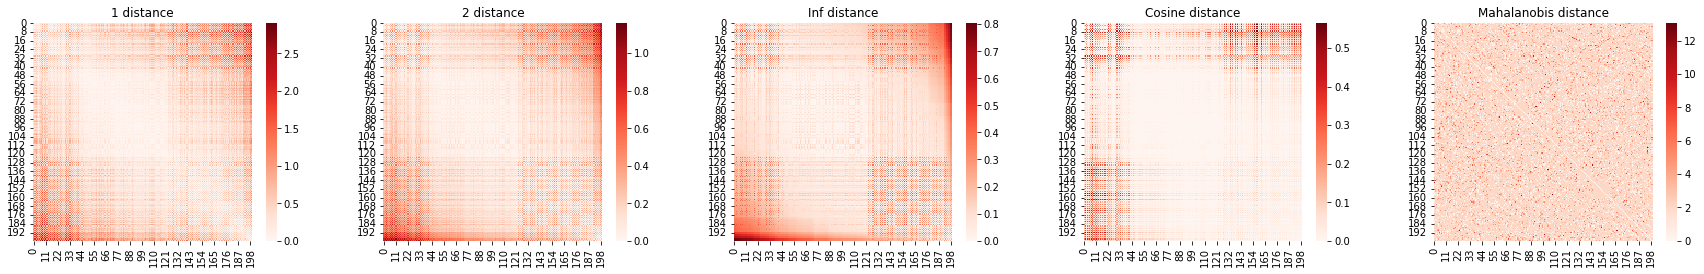

In [ ]:
types = [1, 2, np.inf, 'cosine', 'mahalanobis']

fig, axes = plt.subplots(1,len(types), figsize=(len(types)*5,5))
for type, ax in zip(types, axes.flat):
    d = distanceMatrix(data, type)
    sns.heatmap(d, linewidth=0 , cmap='Reds', ax=ax)
    ax.set_title(f'{str(type).title()} distance')

plt.rcParams.update({'font.size': 10})
plt.tight_layout(pad=5)
plt.show()

##Low Dimension

In [ ]:
fit = umap.UMAP(metric='euclidean',
                n_components=2,
                random_state=0,
                n_neighbors=5,
                min_dist=0.3)
data_low = fit.fit_transform(data)

# normalize the data to 0 1
data_low = normalized(data_low)

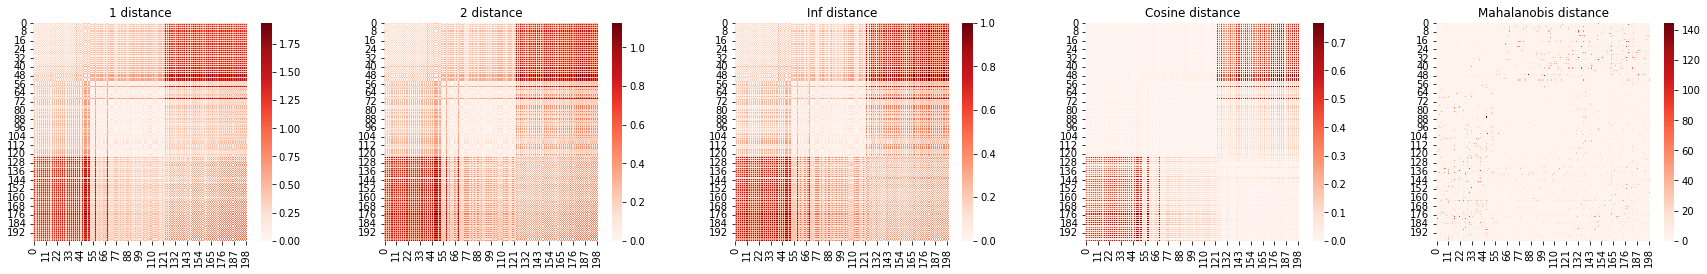

In [ ]:
types = [1, 2, np.inf, 'cosine', 'mahalanobis']

fig, axes = plt.subplots(1,len(types), figsize=(len(types)*5,5))
for type, ax in zip(types, axes.flat):
    d = distanceMatrix(data_low, type)
    sns.heatmap(d, linewidth=0 , cmap='Reds', ax=ax)
    ax.set_title(f'{str(type).title()} distance')

plt.rcParams.update({'font.size': 10})
plt.tight_layout(pad=5)
plt.show()

##High Dimension

In [ ]:
X = data
input_layer = Input(shape=(X.shape[1],))
encoded = Dense(5, activation='sigmoid')(input_layer)
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

X1, X2, Y1, Y2 = train_test_split(X, X, test_size=0.3, random_state=101)

autoencoder.fit(X1, Y1,
                epochs=100,
                batch_size=300,
                shuffle=True,
                verbose = False,
                validation_data=(X2, Y2))

encoder = Model(input_layer, encoded)
data_high = encoder.predict(X)

7/7 [==============================] - 0s 2ms/step


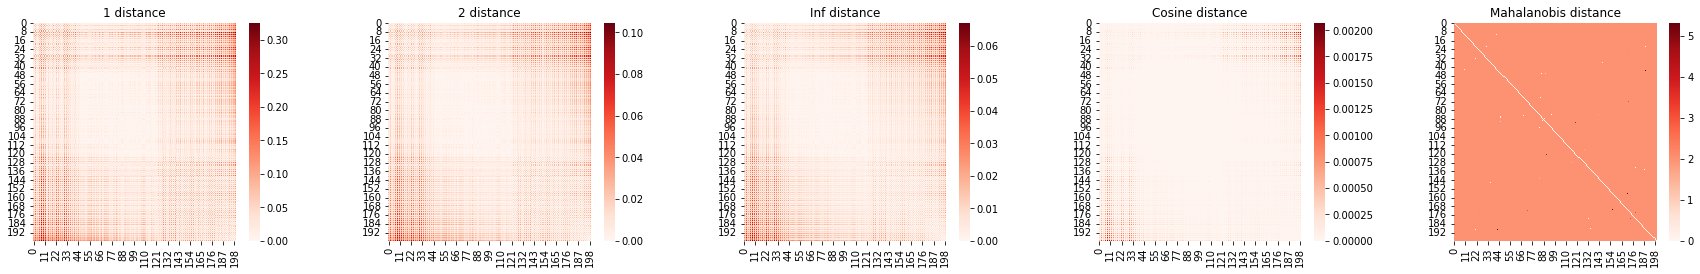

In [ ]:
types = [1, 2, np.inf, 'cosine', 'mahalanobis']

fig, axes = plt.subplots(1,len(types), figsize=(len(types)*5,5))
for type, ax in zip(types, axes.flat):
    d = distanceMatrix(data_high, type)
    sns.heatmap(d, linewidth=0 , cmap='Reds', ax=ax)
    ax.set_title(f'{str(type).title()} distance')

plt.rcParams.update({'font.size': 10})
plt.tight_layout(pad=5)
plt.show()

# Experiments

Como se puedo observar, la distancia de mahalanobias no funciono para ninguno de los 3 conjuntos de datos, por lo que esta no se usara.

Esta vez como se quiere experimentar como caso real, se dividira en train(80%) y test(20%)

##Original data set

In [ ]:
data=data_loader('Real')
data=data.drop('Gender',axis=1)
data=normalized(data)
data=data[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

As the mountain and reduction algorithms are exploratory, we will take the output as the number of centroids, we wont analize if the location of those is good or bad 

The experiments will consis on changings the distance (not mahalanobi), changing the sigma and the n grid 

###Exploration

In [ ]:
mon_ori_num_centers_eucli=np.zeros((6, 6))
for i in range(3,9): # for the number of n_grid
  for j in range(1,7):
    sigma=j*0.025
    centers_eucli, idx_centers, density_centers, density = mountain_clustering_olguis(
        data_train, i, sigma)
    mon_ori_num_centers_eucli[i-3,j-1]=centers_eucli.shape[0]
    
mon_ori_num_centers_manha=np.zeros((6, 6))
for i in range(3,9): # for the number of n_grid
  for j in range(1,7):
    sigma=j*0.025
    centers_manha, idx_centers, density_centers, density = mountain_clustering_olguis(
        data_train, i, sigma, dist_type=1)
    mon_ori_num_centers_manha[i-3,j-1]=centers_manha.shape[0]

mon_ori_num_centers_cos=np.zeros((6, 6))
for i in range(3,9): # for the number of n_grid
  for j in range(1,7):
    sigma=j*0.025
    centers_cos, idx_centers, density_centers, density = mountain_clustering_olguis(
        data_train, i, sigma, dist_type='cos')
    mon_ori_num_centers_cos[i-3,j-1]=centers_cos.shape[0]

<ipython-input-10-2d7fcad702e8>:3: RuntimeWarning:

invalid value encountered in double_scalars



In [ ]:
max_val = np.max(mon_ori_num_centers_eucli)
print("Maximum value:", max_val)
median_val = np.median(mon_ori_num_centers_eucli)
print("Median value:", median_val)
mode_val = stats.mode(mon_ori_num_centers_eucli)[0][0]
print("Mode value:", mode_val)
min_val = np.min(mon_ori_num_centers_eucli)
print("Minimum value:", min_val)
mon_ori_num_centers_eucli

Maximum value: 29.0
Median value: 4.5
Mode value: [1. 9. 9. 5. 2. 2.]
Minimum value: 1.0


<ipython-input-93-958fbd01fc67>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[ 1.,  2.,  9.,  5.,  2.,  2.],
       [ 5.,  9.,  9.,  5.,  4.,  2.],
       [ 8.,  6.,  7.,  4.,  3.,  3.],
       [18.,  8.,  4.,  3.,  3.,  2.],
       [20., 10.,  9.,  5.,  2.,  2.],
       [29.,  9.,  5.,  4.,  2.,  2.]])

In [ ]:
max_val = np.max(mon_ori_num_centers_manha)
print("Maximum value:", max_val)
median_val = np.median(mon_ori_num_centers_manha)
print("Median value:", median_val)
mode_val = stats.mode(mon_ori_num_centers_manha)[0][0]
print("Mode value:", mode_val)
min_val = np.min(mon_ori_num_centers_manha)
print("Minimum value:", min_val)
mon_ori_num_centers_manha

Maximum value: 31.0
Median value: 7.0
Mode value: [ 1.  2. 12.  6.  5.  5.]
Minimum value: 1.0


<ipython-input-94-f8ba74417f2a>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[ 1.,  2.,  7.,  9.,  5.,  5.],
       [ 5., 10., 10.,  6.,  5.,  5.],
       [ 8.,  8., 12.,  7.,  6.,  5.],
       [16., 16.,  8.,  7.,  7.,  6.],
       [19., 21., 12.,  8.,  6.,  4.],
       [31., 17.,  9.,  6.,  7.,  5.]])

In [ ]:
max_val = np.max(mon_ori_num_centers_cos)
print("Maximum value:", max_val)
median_val = np.median(mon_ori_num_centers_cos)
print("Median value:", median_val)
mode_val = stats.mode(mon_ori_num_centers_cos)[0][0]
print("Mode value:", mode_val)
min_val = np.min(mon_ori_num_centers_cos)
print("Minimum value:", min_val)
mon_ori_num_centers_cos

Maximum value: 6.0
Median value: 1.0
Mode value: [5. 3. 1. 1. 1. 1.]
Minimum value: 1.0


<ipython-input-95-bd26866a201a>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[6., 3., 3., 1., 1., 1.],
       [6., 3., 1., 1., 1., 1.],
       [6., 3., 1., 1., 1., 1.],
       [5., 3., 1., 1., 1., 1.],
       [5., 3., 1., 1., 1., 1.],
       [5., 3., 1., 1., 1., 1.]])

The maximun and the minimum nodes won't be taking in to account, just the median and mode nodes as the make more sence (greater than 0)

array([1., 6., 3., 1., 2., 2.])

The same will be applies to the reduction algoritm, changing how the sigma is constructed

In [ ]:
sigma_iter=8
redu_ori_num_centers_eucli=np.zeros((1, sigma_iter-1))
for j in range(1,sigma_iter):
  sigma=j*0.2
  centers_eucli, idx_centers, density_centers, density = reduction_no_cluster_num(
        data_train, sigma)
  redu_ori_num_centers_eucli[0,j-1]=centers_eucli.shape[0]
    
redu_ori_num_centers_manha=np.zeros((1, sigma_iter-1))
for j in range(1,sigma_iter):
  sigma=j*0.2
  centers_manha, idx_centers, density_centers, density = reduction_no_cluster_num(
      data_train, sigma, dist_type=1)
  redu_ori_num_centers_manha[0,j-1]=centers_manha.shape[0]

redu_ori_num_centers_cos=np.zeros((1, sigma_iter-1))
for j in range(1,sigma_iter):
  sigma=j*0.08
  centers_cos, idx_centers, density_centers, density = reduction_no_cluster_num(
       data_train, sigma, dist_type='cos')
  redu_ori_num_centers_cos[0,j-1]=centers_cos.shape[0]

In [ ]:
max_val = np.max(redu_ori_num_centers_eucli)
print("Maximum value:", max_val)
median_val = np.median(redu_ori_num_centers_eucli)
print("Median value:", median_val)
mode_val = stats.mode(redu_ori_num_centers_eucli)[0][0]
print("Mode value:", mode_val)
min_val = np.min(redu_ori_num_centers_eucli)
print("Minimum value:", min_val)
redu_ori_num_centers_eucli

Maximum value: 33.0
Median value: 1.0
Mode value: [33.  9.  3.  1.  1.  1.  1.]
Minimum value: 1.0


<ipython-input-101-e3ab94a6d71f>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[33.,  9.,  3.,  1.,  1.,  1.,  1.]])

In [ ]:
max_val = np.max(redu_ori_num_centers_manha)
print("Maximum value:", max_val)
median_val = np.median(redu_ori_num_centers_manha)
print("Median value:", median_val)
mode_val = stats.mode(redu_ori_num_centers_manha)[0][0]
print("Mode value:", mode_val)
min_val = np.min(redu_ori_num_centers_manha)
print("Minimum value:", min_val)
redu_ori_num_centers_manha

Maximum value: 68.0
Median value: 3.0
Mode value: [68. 17. 10.  3.  2.  1.  1.]
Minimum value: 1.0


<ipython-input-102-0603ab39e26b>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[68., 17., 10.,  3.,  2.,  1.,  1.]])

In [ ]:
max_val = np.max(redu_ori_num_centers_cos)
print("Maximum value:", max_val)
median_val = np.median(redu_ori_num_centers_cos)
print("Median value:", median_val)
mode_val = stats.mode(redu_ori_num_centers_cos)[0][0]
print("Mode value:", mode_val)
min_val = np.min(redu_ori_num_centers_cos)
print("Minimum value:", min_val)
redu_ori_num_centers_cos

Maximum value: 6.0
Median value: 1.0
Mode value: [6. 4. 3. 1. 1. 1. 1.]
Minimum value: 1.0


<ipython-input-103-cff213cd3a2c>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[6., 4., 3., 1., 1., 1., 1.]])

### Number of nodes aplication

As the list of median and mode can be large, just the 3 most centered values will be taken in to account.

in this case the mos middle values are [3,5,6]

####k means

In [ ]:
centers, membership, costs = kmeans(data,3)
plot_group_3d(data, centers, 2)

In [ ]:
centers, membership, costs = kmeans(data,5)
plot_group_3d(data, centers, 2)

In [ ]:
centers, membership, costs = kmeans(data,6)
plot_group_3d(data, centers, 2)

####fuzzy c means

In [ ]:
centers, membership, costs= fuzzyCmeans(data,3)
plot_group_3d(data, centers, 2)

In [ ]:
centers, membership, costs= fuzzyCmeans(data,5)
plot_group_3d(data, centers, 2)

In [ ]:
centers, membership, costs= fuzzyCmeans(data,6)
plot_group_3d(data, centers, 2)

####k medoids

In [ ]:
medoids, clusters = k_medoids(data,3)
plot_group_3d(data, medoids, 2)

In [ ]:
medoids, clusters = k_medoids(data,5)
plot_group_3d(data, medoids, 2)

In [ ]:
medoids, clusters = k_medoids(data,6)
plot_group_3d(data, medoids, 2)

Concluciones

##Higher dimension

In [ ]:
X = data
input_layer = Input(shape=(X.shape[1],))
encoded = Dense(5, activation='sigmoid')(input_layer)
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

X1, X2, Y1, Y2 = train_test_split(X, X, test_size=0.3, random_state=101)

autoencoder.fit(X1, Y1,
                epochs=100,
                batch_size=300,
                shuffle=True,
                verbose = False,
                validation_data=(X2, Y2))

encoder = Model(input_layer, encoded)
data_high = encoder.predict(X)



7/7 [==============================] - 0s 2ms/step


In [ ]:
data_high = normalized(data_high)

In [ ]:
data_train_high, data_test_high = train_test_split(data_high, test_size=0.2, random_state=42)

###Exploration

In [ ]:
mon_hi_num_centers_eucli=np.zeros((3, 6))
for i in range(3,6): # for the number of n_grid
  for j in range(1,7):
    sigma=j*0.025
    centers_eucli_hi, idx_centers, density_centers, density = mountain_clustering_olguis(
        data_train_high, i, sigma)
    mon_hi_num_centers_eucli[i-3,j-1]=centers_eucli_hi.shape[0]
    
mon_hi_num_centers_manha=np.zeros((3, 6))
for i in range(3,6): # for the number of n_grid
  for j in range(1,7):
    sigma=j*0.025
    centers_manha_hi, idx_centers, density_centers, density = mountain_clustering_olguis(
        data_train_high, i, sigma, dist_type=1)
    mon_hi_num_centers_manha[i-3,j-1]=centers_manha_hi.shape[0]

mon_hi_num_centers_cos=np.zeros((3, 6))
for i in range(3,6): # for the number of n_grid
  for j in range(1,7):
    sigma=j*0.025
    centers_cos_hi, idx_centers, density_centers, density = mountain_clustering_olguis(
        data_train_high, i, sigma, dist_type='cos')
    mon_hi_num_centers_cos[i-3,j-1]=centers_cos_hi.shape[0]

<ipython-input-10-2d7fcad702e8>:3: RuntimeWarning:

invalid value encountered in double_scalars



In [ ]:
max_val = np.max(mon_hi_num_centers_eucli)
print("Maximum value:", max_val)
median_val = np.median(mon_hi_num_centers_eucli)
print("Median value:", median_val)
mode_val = stats.mode(mon_hi_num_centers_eucli)[0][0]
print("Mode value:", mode_val)
min_val = np.min(mon_hi_num_centers_eucli)
print("Minimum value:", min_val)
mon_hi_num_centers_eucli

Maximum value: 8.0
Median value: 2.0
Mode value: [0. 0. 2. 1. 1. 2.]
Minimum value: 0.0


<ipython-input-128-2527bfda9c03>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[0., 0., 4., 3., 2., 2.],
       [0., 8., 2., 1., 1., 2.],
       [3., 5., 2., 1., 1., 2.]])

In [ ]:
max_val = np.max(mon_hi_num_centers_manha)
print("Maximum value:", max_val)
median_val = np.median(mon_hi_num_centers_manha)
print("Median value:", median_val)
mode_val = stats.mode(mon_hi_num_centers_manha)[0][0]
print("Mode value:", mode_val)
min_val = np.min(mon_hi_num_centers_manha)
print("Minimum value:", min_val)
mon_hi_num_centers_manha

Maximum value: 5.0
Median value: 2.0
Mode value: [0. 0. 0. 1. 2. 2.]
Minimum value: 0.0


<ipython-input-129-ceec48c14aec>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[0., 0., 0., 1., 4., 2.],
       [0., 1., 3., 2., 2., 2.],
       [0., 5., 5., 5., 5., 2.]])

In [ ]:
max_val = np.max(mon_hi_num_centers_cos)
print("Maximum value:", max_val)
median_val = np.median(mon_hi_num_centers_cos)
print("Median value:", median_val)
mode_val = stats.mode(mon_hi_num_centers_cos)[0][0]
print("Mode value:", mode_val)
min_val = np.min(mon_hi_num_centers_cos)
print("Minimum value:", min_val)
mon_hi_num_centers_cos

Maximum value: 4.0
Median value: 1.0
Mode value: [4. 1. 1. 1. 1. 1.]
Minimum value: 1.0


<ipython-input-130-2f412fe288fd>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[2., 1., 1., 1., 1., 1.],
       [4., 1., 1., 1., 1., 1.],
       [4., 1., 1., 1., 1., 1.]])

In [ ]:
sigma_iter=7
redu_hi_num_centers_eucli=np.zeros((1, sigma_iter-1))
for j in range(1,sigma_iter):
  sigma=j*0.2
  centers_eucli, idx_centers, density_centers, density = reduction_no_cluster_num(
        data_train_high, sigma)
  redu_hi_num_centers_eucli[0,j-1]=centers_eucli.shape[0]
    
redu_hi_num_centers_manha=np.zeros((1, sigma_iter-1))
for j in range(1,sigma_iter):
  sigma=j*0.2
  centers_manha, idx_centers, density_centers, density = reduction_no_cluster_num(
      data_train_high, sigma, dist_type=1)
  redu_hi_num_centers_manha[0,j-1]=centers_manha.shape[0]

redu_hi_num_centers_cos=np.zeros((1, sigma_iter-1))
for j in range(1,sigma_iter):
  sigma=j*0.08
  centers_cos, idx_centers, density_centers, density = reduction_no_cluster_num(
       data_train_high, sigma, dist_type='cos')
  redu_hi_num_centers_cos[0,j-1]=centers_cos.shape[0]

In [ ]:
max_val = np.max(redu_hi_num_centers_eucli)
print("Maximum value:", max_val)
median_val = np.median(redu_hi_num_centers_eucli)
print("Median value:", median_val)
mode_val = stats.mode(redu_hi_num_centers_eucli)[0][0]
print("Mode value:", mode_val)
min_val = np.min(redu_hi_num_centers_eucli)
print("Minimum value:", min_val)
redu_hi_num_centers_eucli

Maximum value: 16.0
Median value: 1.0
Mode value: [16.  2.  1.  1.  1.  1.]
Minimum value: 1.0


<ipython-input-132-4147b535ff8d>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[16.,  2.,  1.,  1.,  1.,  1.]])

In [ ]:
max_val = np.max(redu_hi_num_centers_manha)
print("Maximum value:", max_val)
median_val = np.median(redu_hi_num_centers_manha)
print("Median value:", median_val)
mode_val = stats.mode(redu_hi_num_centers_manha)[0][0]
print("Mode value:", mode_val)
min_val = np.min(redu_hi_num_centers_manha)
print("Minimum value:", min_val)
redu_hi_num_centers_manha

Maximum value: 48.0
Median value: 4.0
Mode value: [48. 12.  5.  3.  1.  1.]
Minimum value: 1.0


<ipython-input-133-23529139ba2a>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[48., 12.,  5.,  3.,  1.,  1.]])

In [ ]:
max_val = np.max(redu_hi_num_centers_cos)
print("Maximum value:", max_val)
median_val = np.median(redu_hi_num_centers_cos)
print("Median value:", median_val)
mode_val = stats.mode(redu_hi_num_centers_cos)[0][0]
print("Mode value:", mode_val)
min_val = np.min(redu_hi_num_centers_cos)
print("Minimum value:", min_val)
redu_hi_num_centers_cos

Maximum value: 1.0
Median value: 1.0
Mode value: [1. 1. 1. 1. 1. 1.]
Minimum value: 1.0


<ipython-input-134-a02d66006d12>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[1., 1., 1., 1., 1., 1.]])

### Number of nodes aplication

As the list of median and mode can be large, just the 3 most centered values will be taken in to account.

in this case the mos middle values are [2,3,5]

####k means

In [ ]:
centers, membership, costs = kmeans(data_high,2)
plot_group_3d(data_high, centers, 2)

In [ ]:
centers, membership, costs = kmeans(data_high,3)
plot_group_3d(data_high, centers, 2)

In [ ]:
centers, membership, costs = kmeans(data_high,5)
plot_group_3d(data_high, centers, 2)

#### fuzzy c means

In [ ]:
centers, membership, costs= fuzzyCmeans(data_high,2)
plot_group_3d(data_high, centers, 2)

In [ ]:
centers, membership, costs= fuzzyCmeans(data_high,3)
plot_group_3d(data_high, centers, 2)

In [ ]:
centers, membership, costs= fuzzyCmeans(data_high,5)
plot_group_3d(data_high, centers, 2)

####k medoids

In [ ]:
medoids, clusters = k_medoids(data_high,2)
plot_group_3d(data_high, medoids, 2)

In [ ]:
medoids, clusters = k_medoids(data_high,3)
plot_group_3d(data_high, medoids, 2)

In [ ]:
medoids, clusters = k_medoids(data_high,5)
plot_group_3d(data_high, medoids, 2)

##lower dimension

In [ ]:
fit = umap.UMAP(metric='euclidean',
                n_components=2,
                random_state=0,
                n_neighbors=5,
                min_dist=0.3)
data_low = fit.fit_transform(data)

# normalize the data to 0 1
data_low = normalized(data_low)

In [ ]:
data_train_low, data_test_low = train_test_split(data_low, test_size=0.2, random_state=42)

###Exploration

In [ ]:
mon_lo_num_centers_eucli=np.zeros((6, 6))
for i in range(3,9): # for the number of n_grid
  for j in range(1,7):
    sigma=j*0.025
    centers_eucli, idx_centers, density_centers, density = mountain_clustering_olguis(
        data_train_low, i, sigma)
    mon_lo_num_centers_eucli[i-3,j-1]=centers_eucli.shape[0]
    
mon_lo_num_centers_manha=np.zeros((6, 6))
for i in range(3,9): # for the number of n_grid
  for j in range(1,7):
    sigma=j*0.025
    centers_manha, idx_centers, density_centers, density = mountain_clustering_olguis(
        data_train_low, i, sigma, dist_type=1)
    mon_lo_num_centers_manha[i-3,j-1]=centers_manha.shape[0]

mon_lo_num_centers_cos=np.zeros((6, 6))
for i in range(3,9): # for the number of n_grid
  for j in range(1,7):
    sigma=j*0.025
    centers_cos, idx_centers, density_centers, density = mountain_clustering_olguis(
        data_train_low, i, sigma, dist_type='cos')
    mon_lo_num_centers_cos[i-3,j-1]=centers_cos.shape[0]

<ipython-input-10-2d7fcad702e8>:3: RuntimeWarning:

invalid value encountered in double_scalars



In [ ]:
max_val = np.max(mon_lo_num_centers_eucli)
print("Maximum value:", max_val)
median_val = np.median(mon_lo_num_centers_eucli)
print("Median value:", median_val)
mode_val = stats.mode(mon_lo_num_centers_eucli)[0][0]
print("Mode value:", mode_val)
min_val = np.min(mon_lo_num_centers_eucli)
print("Minimum value:", min_val)
mon_lo_num_centers_eucli

Maximum value: 8.0
Median value: 3.0
Mode value: [7. 3. 4. 3. 1. 1.]
Minimum value: 1.0


<ipython-input-288-46f2025d2d85>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[2., 3., 2., 2., 2., 2.],
       [4., 3., 3., 3., 1., 1.],
       [7., 5., 4., 3., 3., 1.],
       [8., 5., 3., 3., 1., 1.],
       [7., 3., 4., 3., 1., 1.],
       [7., 4., 4., 3., 3., 1.]])

In [ ]:
max_val = np.max(mon_lo_num_centers_manha)
print("Maximum value:", max_val)
median_val = np.median(mon_lo_num_centers_manha)
print("Median value:", median_val)
mode_val = stats.mode(mon_lo_num_centers_manha)[0][0]
print("Mode value:", mode_val)
min_val = np.min(mon_lo_num_centers_manha)
print("Minimum value:", min_val)
mon_lo_num_centers_manha

Maximum value: 9.0
Median value: 3.0
Mode value: [7. 5. 4. 3. 3. 1.]
Minimum value: 1.0


<ipython-input-153-4f61e04b2db5>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[1., 3., 2., 1., 1., 1.],
       [4., 3., 4., 3., 3., 1.],
       [6., 5., 5., 3., 3., 3.],
       [7., 5., 5., 3., 3., 1.],
       [7., 5., 4., 3., 3., 3.],
       [9., 5., 4., 3., 3., 3.]])

In [ ]:
max_val = np.max(mon_lo_num_centers_cos)
print("Maximum value:", max_val)
median_val = np.median(mon_lo_num_centers_cos)
print("Median value:", median_val)
mode_val = stats.mode(mon_lo_num_centers_cos)[0][0]
print("Mode value:", mode_val)
min_val = np.min(mon_lo_num_centers_cos)
print("Minimum value:", min_val)
mon_lo_num_centers_cos

Maximum value: 3.0
Median value: 1.0
Mode value: [3. 2. 1. 1. 1. 1.]
Minimum value: 1.0


<ipython-input-154-343af6f2ffab>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[3., 1., 1., 1., 1., 1.],
       [3., 1., 1., 1., 1., 1.],
       [3., 2., 1., 1., 1., 1.],
       [3., 2., 1., 1., 1., 1.],
       [3., 2., 1., 1., 1., 1.],
       [3., 2., 1., 1., 1., 1.]])

In [ ]:
sigma_iter=7
redu_lo_num_centers_eucli=np.zeros((1, sigma_iter-1))
for j in range(1,sigma_iter):
  sigma=j*0.2
  centers_eucli, idx_centers, density_centers, density = reduction_no_cluster_num(
        data_train_low, sigma)
  redu_lo_num_centers_eucli[0,j-1]=centers_eucli.shape[0]
    
redu_lo_num_centers_manha=np.zeros((1, sigma_iter-1))
for j in range(1,sigma_iter):
  sigma=j*0.2
  centers_manha, idx_centers, density_centers, density = reduction_no_cluster_num(
      data_train_low, sigma, dist_type=1)
  redu_lo_num_centers_manha[0,j-1]=centers_manha.shape[0]

redu_lo_num_centers_cos=np.zeros((1, sigma_iter-1))
for j in range(1,sigma_iter):
  sigma=j*0.08
  centers_cos, idx_centers, density_centers, density = reduction_no_cluster_num(
       data_train_low, sigma, dist_type='cos')
  redu_lo_num_centers_cos[0,j-1]=centers_cos.shape[0]

In [ ]:
max_val = np.max(redu_lo_num_centers_eucli)
print("Maximum value:", max_val)
median_val = np.median(redu_lo_num_centers_eucli)
print("Median value:", median_val)
mode_val = stats.mode(redu_lo_num_centers_eucli)[0][0]
print("Mode value:", mode_val)
min_val = np.min(redu_lo_num_centers_eucli)
print("Minimum value:", min_val)
redu_lo_num_centers_eucli

Maximum value: 6.0
Median value: 1.5
Mode value: [6. 2. 2. 1. 1. 1.]
Minimum value: 1.0


<ipython-input-156-ec43c954d58e>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[6., 2., 2., 1., 1., 1.]])

In [ ]:
max_val = np.max(redu_lo_num_centers_manha)
print("Maximum value:", max_val)
median_val = np.median(redu_lo_num_centers_manha)
print("Median value:", median_val)
mode_val = stats.mode(redu_lo_num_centers_manha)[0][0]
print("Mode value:", mode_val)
min_val = np.min(redu_lo_num_centers_manha)
print("Minimum value:", min_val)
redu_lo_num_centers_manha

Maximum value: 9.0
Median value: 2.0
Mode value: [9. 4. 2. 2. 1. 1.]
Minimum value: 1.0


<ipython-input-157-b4a27e3c3fa3>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[9., 4., 2., 2., 1., 1.]])

In [ ]:
max_val = np.max(redu_lo_num_centers_cos)
print("Maximum value:", max_val)
median_val = np.median(redu_lo_num_centers_cos)
print("Median value:", median_val)
mode_val = stats.mode(redu_lo_num_centers_cos)[0][0]
print("Mode value:", mode_val)
min_val = np.min(redu_lo_num_centers_cos)
print("Minimum value:", min_val)
redu_lo_num_centers_cos

Maximum value: 3.0
Median value: 1.5
Mode value: [3. 2. 2. 1. 1. 1.]
Minimum value: 1.0


<ipython-input-158-4e7cc29a2597>:5: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([[3., 2., 2., 1., 1., 1.]])

###Number of nodes aplication

As the list of median and mode can be large, just the 3 most centered values will be taken in to account.

in this case the mos middle values are [2,3,6]

####k means

In [ ]:
centers, membership, costs = kmeans(data_low,2)
plot_group_2d(data_low, centers, 2)

In [ ]:
centers, membership, costs = kmeans(data_low,3)
plot_group_2d(data_low, centers, 2)

In [ ]:
centers, membership, costs = kmeans(data_low,6)
plot_group_2d(data_low, centers, 2)

####fuzzy c means

In [ ]:
centers, membership, costs= fuzzyCmeans(data_low,2)
plot_group_2d(data_low, centers, 2)

In [ ]:
centers, membership, costs= fuzzyCmeans(data_low,3)
plot_group_2d(data_low, centers, 2)

In [ ]:
centers, membership, costs= fuzzyCmeans(data_low,6)
plot_group_2d(data_low, centers, 2)

####k modoids

In [ ]:
medoids, clusters = k_medoids(data_low,2)
plot_group_2d(data_low, medoids, 2)

In [ ]:
medoids, clusters = k_medoids(data_low,3)
plot_group_2d(data_low, medoids, 2)

In [ ]:
medoids, clusters = k_medoids(data_low,6)
plot_group_2d(data_low, medoids, 2)